In [ ]:

# %cd /content/DataScience/CelebrityFaceRecognition/model



/content/DataScience/CelebrityFaceRecognition/model


In [ ]:
import os
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

img_dirs = []

for entry in os.scandir(path_to_data):
  if entry.is_dir():
    img_dirs.append(entry.path)

img_dirs

['./dataset/serena_williams',
 './dataset/roger_federer',
 './dataset/cropped',
 './dataset/lionel_messi',
 './dataset/virat_kohli',
 './dataset/maria_sharapova']

In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_frontalface_default.xml")

eye_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_eye.xml")

In [ ]:
def get_cropped_faces(img):
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray_img, 1.3,5)
  face_arr= []
  for (x,y,w,h) in faces:
    roi_gray = gray_img[y:y+h,x:x+w]
    roi_color = img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray,1.3,5)

    if len(eyes)<2: continue

    face_arr.append(roi_color)

  return face_arr



In [ ]:
import shutil
if os.path.exists(path_to_cr_data): shutil.rmtree(path_to_cr_data)

os.mkdir(path_to_cr_data)

In [ ]:
celebrity_dict = {}

for img_dir in img_dirs:
  name = img_dir.split("/")[-1]
  count = 0
  # celebrity images handleling
  os.mkdir(os.path.join(path_to_cr_data,name))

  for entry in os.scandir(img_dir):
    if not entry.is_file(): continue
    img = cv2.imread(entry.path)
    img_arr= get_cropped_faces(img)


    for cropped_img in img_arr:
      file_name = name+ str(count) +".png"
      file_path = os.path.join(path_to_cr_data,name, file_name)
      # print(file_path)
      cv2.imwrite(file_path,cropped_img)

      if name not in celebrity_dict: celebrity_dict[name] = []
      celebrity_dict[name].append(file_path)
      count+=1

# celebrity_dict








# Feature Extraction

In [ ]:
#  wavelet transform function
import cv2
import numpy as np
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float

    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)



    return imArray_H




In [ ]:
import matplotlib.pyplot as plt



In [ ]:
x = []
y = []
celebrity_ind = {}
ind = 0
for celebrity_name, training_files in celebrity_dict.items():
    celebrity_ind[celebrity_name] = ind
    ind+=1
    for training_img in training_files:
        img = cv2.imread(training_img)

        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, "db1", 5)

        scaled_har_img = cv2.resize(img_har, (32, 32))

        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_har_img.reshape(32*32, 1)))
        x.append(combined_img)
        y.append(celebrity_ind[celebrity_name])


In [ ]:
print(len(x), x[0].shape)

# len(x) gives no of images, x[i] represent image
# we have to convert the image (x[i]) to linear form

134 (4096, 1)


In [ ]:
x = np.array(x).reshape(len(x), 4096).astype(float)


In [ ]:
print(x)

[[233. 202. 221. ... 253. 119. 198.]
 [ 78.  72.  73. ... 229.   4.   3.]
 [ 26.  21.  22. ... 248.   9. 248.]
 ...
 [  1.   1.   1. ...  26.  32.   5.]
 [ 34.  24.  18. ...  32.  13.  44.]
 [247. 241. 246. ...   1. 198.   8.]]


# Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()),"svm", SVC()])

models = {
    "svm":{
        "model":SVC(probability=True),
        "params":{
             "svm__C":[10,1,0.1,0.01],
            "svm__kernel": ["linear", "rbf"]
        }
    },

    "logistic_regression":{
        "model": LogisticRegression(max_iter=10000000),
        "params":{
            "logistic_regression__solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
            "logistic_regression__C":[1,0.1,0.01],



        }
    }
}


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [ ]:
result = {}
best_est = {}
for algo,model in models.items():
  pipe = Pipeline([("scaler", StandardScaler()),(algo, model["model"])])
  clf = GridSearchCV(pipe,model["params"], cv=5)
  clf.fit(x_train,y_train)
  result[algo] = {
      "best_score": clf.best_score_,
      "best_params": clf.best_params_,
  }
  best_est[algo] = clf.best_estimator_



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
import pandas as pd

df = pd.DataFrame(result)
df

,svm,logistic_regression
best_score,0.72,0.74
best_params,"{'svm__C': 10, 'svm__kernel': 'linear'}","{'logistic_regression__C': 0.1, 'logistic_regr..."


In [ ]:

best_est["svm"].score(x_test, y_test)

0.9117647058823529

In [ ]:
best_est["logistic_regression"].score(x_test, y_test)

0.8823529411764706

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = best_est["svm"].predict(x_test)
cm = confusion_matrix(y_test,y_pred)
cm



array([[6, 0, 0, 0, 2],
       [0, 2, 0, 0, 1],
       [0, 0, 7, 0, 0],
       [0, 0, 0, 9, 0],
       [0, 0, 0, 0, 7]])

Text(33.22222222222222, 0.5, 'Truth')

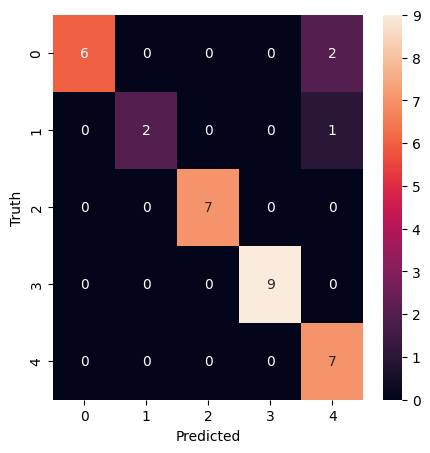

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
import json
with open("celebrity_ind.txt","w") as f:
  f.write(json.dumps(celebrity_ind))


In [ ]:
import joblib

joblib.dump(best_est["svm"], "celebrity_recog_model.pkl")


['celebrity_recog_model.pkl']